In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
import json

# Importing my config file to access easier-to-set variables
config = {}
with open('config.json') as config_json:
    config = json.load(config_json)

lags= config['lags']

In [44]:
# Getting dataframe from csv file scraped in yahooscrape.py
data = pd.read_csv('{}_{}_{}_stock_data.csv'.format(config['company'], config['params']['range'], config['params']['interval']), index_col=0)

print('Importing {} Stock Data'.format(config['company']))
data.describe()

Importing GME Stock Data


,Open,High,Low,Close,Adj Close,Volume
count,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1.259000e+03
mean,16.645171,17.320254,16.002724,16.597260,14.527490,5.312986e+06
std,18.167707,22.658292,13.135001,16.782552,15.943551,1.197841e+07
min,2.850000,2.940000,2.570000,2.800000,2.800000,9.729000e+05
25%,6.650000,6.975000,6.320000,6.680000,6.680000,2.150450e+06
50%,15.190000,15.460000,14.880000,15.220000,13.972721,3.037400e+06
75%,22.755000,23.185001,22.455000,22.810001,18.929360,4.664950e+06
max,379.709991,483.000000,250.000000,347.510010,347.510010,1.967843e+08


<AxesSubplot:xlabel='Date'>

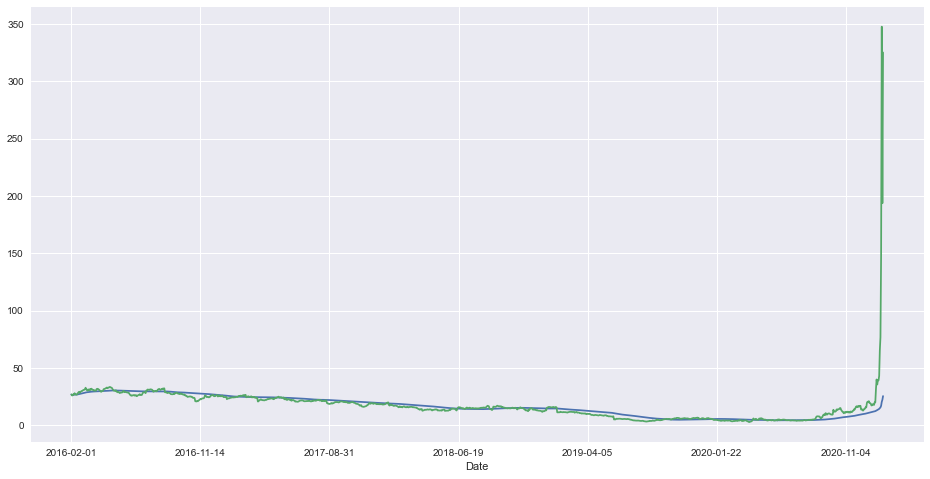

In [45]:
# 100 day moving average
data['100ma'] = data['Close'].rolling(window= lags, min_periods= 0).mean()

# TS Plots
plt.figure(figsize= (16,8))
data['100ma'].plot()
data.Close.plot()

In [46]:
# Dropping Na values -- despite this being fairly continuous data, there are still na values in places, perhaps due to system error or market holidays?
data.dropna(inplace= True)

In [47]:
#Create Dataframe that only has the 'Close' column.
c_data = data.filter(['Close'])
c_data.head()

,Close
Date,
2016-02-01,26.809999
2016-02-02,25.920000
2016-02-03,26.170000
2016-02-04,27.010000
2016-02-05,26.830000


to predict you must take some of the first values and use them to predict the same value some point in the future
eg, use the first 30 values of closing price to predict the 31st, each time you make a prediction you move that window forward such that value X is predicted using values ranging from X-30: X

[follow this guide](https://data-flair.training/blogs/stock-price-prediction-machine-learning-project-in-python/)

In [48]:
# Creating the train-test split
c_data_val = c_data.values

train_data = c_data_val[:int(len(c_data) * .66)]
test_data = c_data_val[int(len(c_data) * .66):]

print(len(train_data), len(test_data), len(train_data) + len(test_data), len(c_data))

830 429 1259 1259


In [49]:
# Looping through and appending lagged data to arrays used for training and testing the gradient boosting model
x_train_data, y_train_data = [], []
for i in range(lags, len(train_data)):
    x_train_data.append(train_data[i-lags:i,0])
    y_train_data.append(train_data[i,0])

x_test_data, y_test_data = [], []
for i in range(lags, len(test_data)):
    x_test_data.append(test_data[i-lags:i,0])
    y_test_data.append(test_data[i,0])


x_train_data, y_train_data = np.array(x_train_data), np.array(y_train_data)
x_train_data= np.reshape(x_train_data, (x_train_data.shape[0], x_train_data.shape[1]))

x_test_data, y_test_data = np.array(x_test_data), np.array(y_test_data)
x_test_data= np.reshape(x_test_data, (x_test_data.shape[0], x_test_data.shape[1]))

In [50]:
# Creating model & setting hyperparameters
from xgboost import XGBRegressor

xgb_model = XGBRegressor(n_estimators= 1500, learning_rate= 0.025, n_jobs= 3)
xgb_model.fit(xtd, y_train_data,
            early_stopping_rounds= 10,
            eval_set= [(x_test_data, y_test_data)],
                verbose= True)

[0]	validation_0-rmse:31.19369
[1]	validation_0-rmse:31.05545
[2]	validation_0-rmse:30.92385
[3]	validation_0-rmse:30.79377
[4]	validation_0-rmse:30.66778
[5]	validation_0-rmse:30.57956
[6]	validation_0-rmse:30.46089
[7]	validation_0-rmse:30.34994
[8]	validation_0-rmse:30.23829
[9]	validation_0-rmse:30.13021
[10]	validation_0-rmse:30.05761
[11]	validation_0-rmse:29.96100
[12]	validation_0-rmse:29.86229
[13]	validation_0-rmse:29.76902
[14]	validation_0-rmse:29.67772
[15]	validation_0-rmse:29.59302
[16]	validation_0-rmse:29.50966
[17]	validation_0-rmse:29.45396
[18]	validation_0-rmse:29.37876
[19]	validation_0-rmse:29.30418
[20]	validation_0-rmse:29.23365
[21]	validation_0-rmse:29.16609
[22]	validation_0-rmse:29.09571
[23]	validation_0-rmse:29.03238
[24]	validation_0-rmse:28.97215
[25]	validation_0-rmse:28.91262
[26]	validation_0-rmse:28.87294
[27]	validation_0-rmse:28.81662
[28]	validation_0-rmse:28.76284
[29]	validation_0-rmse:28.70703
[30]	validation_0-rmse:28.65151
[31]	validation_0-

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.025, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1500, n_jobs=3, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [51]:
# Evaluating model
from sklearn.metrics import mean_absolute_error
prediction = xgb_model.predict(x_test_data)
score = mean_absolute_error(y_test_data, prediction)

print('mean absolute error of prediction is: {}'.format(score))

valid_data= pd.DataFrame(c_data.Close[-(len(x_test_data)):])
valid_data['Predict']= prediction

valid_data


mean absolute error of prediction is: 6.280422980341485


,Close,Predict
Date,,
2019-10-10,5.050000,8.446740
2019-10-11,5.370000,8.446740
2019-10-14,5.580000,8.446740
2019-10-15,5.610000,8.446740
2019-10-16,5.880000,8.446740
...,...,...
2021-01-25,76.790001,25.214342
2021-01-26,147.979996,25.536732
2021-01-27,347.510010,25.514303


While the cell above shows a relatively small error of ~6, looking into the prediction series suggests that the model may not be using the data to learn, the first 600 predicted values are all the same.

The regressor also finds a relatively sizable root mean squared error that minimises at around 27 (For GME at this point in time)

<AxesSubplot:xlabel='Date'>

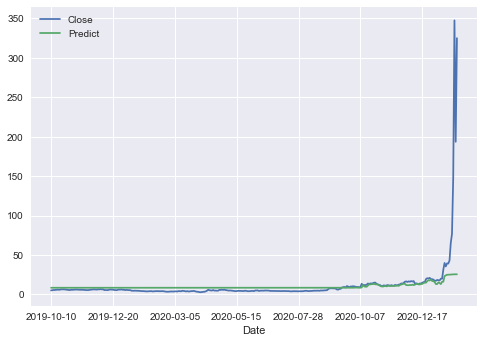

In [52]:
valid_data.plot()